### Boring Setups

In [329]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pylab as plt

In [330]:
dtrain = pd.read_csv('data/train.csv')
dtest = pd.read_csv('data/test.csv')

### Data sizes

In [331]:
dtrain.shape

(614, 13)

In [332]:
dtest.shape

(367, 12)

### Data at a Galance

In [333]:
dtrain.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Features and their Distributions

##### 1 .Feature Names

In [334]:
dtrain.columns.values

array(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Loan_Status'], dtype=object)

##### 2. Null Counts

In [335]:
nullCount = [dtrain[cols].isnull().sum() for cols in dtrain.columns.values]
pd.DataFrame({'Features': dtrain.columns.values, 'Nulls': nullCount})

,Features,Nulls
0,Loan_ID,0
1,Gender,13
2,Married,3
3,Dependents,15
4,Education,0
5,Self_Employed,32
6,ApplicantIncome,0
7,CoapplicantIncome,0
8,LoanAmount,22
9,Loan_Amount_Term,14


##### 3. Data Types & Type Counts

In [336]:
dtrain.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [337]:
dtrain_type = dtrain.dtypes.reset_index()
dtrain_type.columns = ["Count", "Type"]
dtrain_type.groupby('Type').aggregate('count').reset_index()

,Type,Count
0,int64,1
1,float64,4
2,object,8


##### 4. Unique values for categorical Features

In [338]:
categorical_features = ['Gender', 'Married', 
                        'Education', 'Self_Employed', 'Property_Area']
for each in categorical_features:
    print(each + str(dtrain[each].unique()).
          rjust(len(max(dtrain.columns.values.tolist(),
                        key=len)) + 30 - len(each)))

Gender                    ['Male' 'Female' nan]
Married                        ['No' 'Yes' nan]
Education           ['Graduate' 'Not Graduate']
Self_Employed                  ['No' 'Yes' nan]
Property_Area     ['Urban' 'Rural' 'Semiurban']


### Data Cleaning

##### 1. Cleaning NaN values

In [339]:
dtrain.Dependents.unique()

array(['0', '1', '2', '3+', nan], dtype=object)

Let's handle the variable **```Dependents```**. Unique values of dependents are 0, 1, 2, 3+ and NaN. It is natural that entires with NaN values have 0 dependents. So we shall fill NaN with 0 for this column

In [340]:
dtrain.Dependents.fillna(0, inplace=True)
dtest.Dependents.fillna(0, inplace=True)

In [341]:
dtrain.Self_Employed.unique()

array(['No', 'Yes', nan], dtype=object)

Next column is **```Self_Employed```**. If they are self employed then **Yes** else **No**. But then NaN in self employed may mean they are not at all employed. Hence we are filling NaNs with NE(Not Employed). The reason we can not drop entries with NaN is because we have very limited number of 614 data points. Losing any data could be bad.

In [342]:
dtrain.Self_Employed.replace(np.nan, 'NE', inplace=True)
dtest.Self_Employed.replace(np.nan, 'NE', inplace=True)

Next is **```LoanAmount```**. This is a very important feature but we still see some NaNs. We are filling the NaNs with the *median* of all the ```LoanAmount```

In [343]:
dtrain.LoanAmount.replace(np.nan, dtrain.LoanAmount.median(), inplace=True)
dtest.LoanAmount.replace(np.nan, dtest.LoanAmount.median(), inplace=True)

In [344]:
dtrain.Credit_History.unique()

array([  1.,   0.,  nan])

We are handling the **```Credit_History```** and **```Loan_Amount_Term```** in the same way

In [345]:
dtrain.Credit_History.replace(np.nan, dtrain.Credit_History.median(), inplace=True)
dtrain.Loan_Amount_Term.replace(np.nan, dtrain.Loan_Amount_Term.median(), inplace=True)

dtest.Credit_History.replace(np.nan, dtest.Credit_History.median(), inplace=True)
dtest.Loan_Amount_Term.replace(np.nan, dtest.Loan_Amount_Term.median(), inplace=True)

In [346]:
dtrain.Gender.unique()

array(['Male', 'Female', nan], dtype=object)

**```Gender```** is something that would have two values namely, 'Male' and 'Female'. But here we also have NaN. We may consider them as 'Trans' to accomodate the category

In [347]:
dtrain.Gender.replace(np.nan, 'Trans', inplace=True)
dtest.Gender.replace(np.nan, 'Trans', inplace=True)
dtrain.Gender.unique()

array(['Male', 'Female', 'Trans'], dtype=object)

In [348]:
dtrain.Married.unique()

array(['No', 'Yes', nan], dtype=object)

Similarly we can also fill the NaN in **```Married```** as 'Other'. 

In [349]:
dtrain.Married.replace(np.nan, 'Other', inplace=True)
dtest.Married.replace(np.nan, 'Other', inplace=True)

##### 2. Stroring data for EDA

In [350]:
eda_data = dtrain.copy(deep=True)

##### 3. Encoding Categorical Variables

Converting all categorical vairiables into labels to process with Machine Learning

In [351]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
number = LabelEncoder()
bi_number = LabelBinarizer()
dtrain['Married'] = number.fit_transform(dtrain.Married.astype('str'))
dtrain['Loan_Status'] = bi_number.fit_transform(dtrain.Loan_Status.astype('str'))
dtrain['Self_Employed'] = number.fit_transform(dtrain.Self_Employed.astype('str'))

dtest['Married'] = number.fit_transform(dtest.Married.astype('str'))
dtest['Self_Employed'] = number.fit_transform(dtest.Self_Employed.astype('str'))

For *Property_Area*, *Gender* and *Education* we are performing ratio of the counts of True Loan_Status count to the total Loan_Status Count 

In [352]:
import hashlib
def convert_to_hashes(elem):
    return round(int(hashlib.md5(elem.encode('utf-8')).hexdigest(), 16) / 1e35, 5)
dtrain['Gender'] = dtrain['Gender'].apply(convert_to_hashes)
dtest['Gender'] = dtest['Gender'].apply(convert_to_hashes)

In [353]:
property_counts = dtrain.groupby('Property_Area').Loan_Status.value_counts()
# gender_counts = dtrain.groupby('Gender').Loan_Status.value_counts()
edu_count = dtrain.groupby('Education').Loan_Status.value_counts()

In [354]:
# a = (np.array(dtrain.Education ) == 'Graduate')
# b = (np.array(dtrain.Education ) == 'Not Graduate')
# dtrain['Graduate'] = a
# dtrain['Not Graduate'] = b
# dtrain['Graduate'] = dtrain.Graduate.map({True: 1, False: 0})
# dtrain['Not Graduate'] = dtrain.Graduate.map({True: 0, False: 1})
# ls = dtrain.Loan_Status
# dtrain.drop(['Loan_Status', 'Education'], axis=1, inplace=True)
# dtrain['Loan_Status'] = ls

# a = (np.array(dtest.Education ) == 'Graduate')
# b = (np.array(dtest.Education ) == 'Not Graduate')
# dtest['Graduate'] = a
# dtest['Not Graduate'] = b
# dtest['Graduate'] = dtest.Graduate.map({True: 1, False: 0})
# dtest['Not Graduate'] = dtest.Graduate.map({True: 0, False: 1})
# dtest.drop(['Education'], axis=1, inplace=True)

In [355]:
### For Property_Area ###
dtrain.loc[dtrain.Property_Area == 'Rural', 'Property_Area'] = property_counts[0] / (property_counts[0] + 
                                                                                     property_counts[1])
dtrain.loc[dtrain.Property_Area == 'Semiurban', 'Property_Area'] = property_counts[2] / (property_counts[2] + 
                                                                                         property_counts[3])
dtrain.loc[dtrain.Property_Area == 'Urban', 'Property_Area'] = property_counts[4] / (property_counts[4] + 
                                                                                     property_counts[5])

dtest.loc[dtest.Property_Area == 'Rural', 'Property_Area'] = property_counts[0] / (property_counts[0] + 
                                                                                     property_counts[1])
dtest.loc[dtest.Property_Area == 'Semiurban', 'Property_Area'] = property_counts[2] / (property_counts[2] + 
                                                                                         property_counts[3])
dtest.loc[dtest.Property_Area == 'Urban', 'Property_Area'] = property_counts[4] / (property_counts[4] + 
                                                                                     property_counts[5])

### For Gender ###
# dtrain.loc[dtrain.Gender == 'Male', 'Gender'] = gender_counts[2] / (gender_counts[2] + 
#                                                                     gender_counts[3])
# dtrain.loc[dtrain.Gender == 'Female', 'Gender'] = gender_counts[0] / (gender_counts[0] + 
#                                                                       gender_counts[1])
# dtrain.loc[dtrain.Gender == 'Trans', 'Gender'] = gender_counts[4] / (gender_counts[4] + 
#                                                                      gender_counts[5])

# dtest.loc[dtest.Gender == 'Male', 'Gender'] = gender_counts[2] / (gender_counts[2] + 
#                                                                     gender_counts[3])
# dtest.loc[dtest.Gender == 'Female', 'Gender'] = gender_counts[0] / (gender_counts[0] + 
#                                                                       gender_counts[1])
# dtest.loc[dtest.Gender == 'Trans', 'Gender'] = gender_counts[4] / (gender_counts[4] + 
#                                                                      gender_counts[5])
### For Education ###
dtrain.loc[dtrain.Education == 'Graduate', 'Education'] = edu_count[0] / (edu_count[1] + edu_count[0])
dtrain.loc[dtrain.Education == 'Not Graduate', 'Education'] = edu_count[2] / (edu_count[2] + edu_count[3])

dtest.loc[dtest.Education == 'Graduate', 'Education'] = edu_count[0] / (edu_count[1] + edu_count[0])
dtest.loc[dtest.Education == 'Not Graduate', 'Education'] = edu_count[2] / (edu_count[2] + edu_count[3])


In [356]:
dtrain.shape

(614, 13)

We are filling all the **```Dependents```** of value **3+** with a value **6** because on an average number of dependents in a family never becomes more than 9 or 10. So mean of 3 and 9 is 6 hence we are filling it with 9

In [357]:
dtrain.Dependents.replace('3+', 6, inplace=True)
dtest.Dependents.replace('3+', 6, inplace=True)

In [359]:
dtrain.Gender.unique()

array([ 1323.02908,  2433.82711,    16.98884])

##### 4. DataType Conversion

In [360]:
dtrain['Married'] = dtrain.Married.astype(int)
dtrain['Gender'] = dtrain.Gender.astype(float)
dtrain['Dependents'] = dtrain.Dependents.astype(int)
dtrain['Education'] = dtrain.Education.astype(float)
dtrain['Property_Area'] = dtrain.Property_Area.astype(float)

dtest['Married'] = dtest.Married.astype(int)
dtest['Gender'] = dtest.Gender.astype(float)
dtest['Dependents'] = dtest.Dependents.astype(int)
dtest['Education'] = dtest.Education.astype(float)
dtest['Property_Area'] = dtest.Property_Area.astype(float)

In [361]:
# Removing the Outliers
dtrain = dtrain[np.abs(dtrain.ApplicantIncome-dtrain.ApplicantIncome.mean())<=(3*dtrain.ApplicantIncome.std())]
dtrain = dtrain[np.abs(dtrain.CoapplicantIncome-dtrain.CoapplicantIncome.mean())<=(3*dtrain.CoapplicantIncome.std())]
dtrain = dtrain[np.abs(dtrain.LoanAmount-dtrain.LoanAmount.mean())<=(3*dtrain.LoanAmount.std())]
dtrain = dtrain[np.abs(dtrain.Loan_Amount_Term-dtrain.Loan_Amount_Term.mean())<=(3*dtrain.Loan_Amount_Term.std())]

In [362]:
# Putting cleaned train data to a new csv
dtrain.to_csv('data/cleaned_train.csv')
dtest.to_csv('data/cleaned_test.csv')

### Univarite Analysis

##### 1. Distribution of the Loan Amount

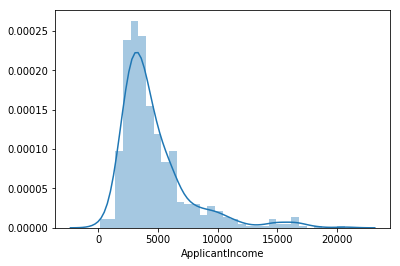

In [363]:
sns.distplot(dtrain.ApplicantIncome)
plt.show()

In [364]:
dtrain.ApplicantIncome.max()

20667

In [369]:
dtrain['Loan_ID'] = dtrain.Loan_ID.apply(convert_to_hashes)

In [370]:
dtrain.corr()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,1.000000,0.018836,-0.091448,0.023294,0.021740,0.061975,0.078535,0.031374,0.035446,-0.023151,-0.064549,0.010282,-0.009413
Gender,0.018836,1.000000,-0.352723,-0.150354,0.025076,-0.044951,-0.034440,-0.181117,-0.155391,0.098881,0.004920,0.076422,-0.000012
Married,-0.091448,-0.352723,1.000000,0.266627,-0.029241,-0.001205,-0.015247,0.238039,0.157480,-0.128082,0.019704,0.016328,0.086811
Dependents,0.023294,-0.150354,0.266627,1.000000,-0.073698,0.036952,0.069918,-0.044890,0.118532,-0.082643,-0.025719,0.013634,0.000928
Education,0.021740,0.025076,-0.029241,-0.073698,1.000000,-0.004356,0.164344,0.032647,0.146121,0.091299,0.077510,0.064100,0.093697
Self_Employed,0.061975,-0.044951,-0.001205,0.036952,-0.004356,1.000000,0.227412,-0.054190,0.088501,-0.022905,-0.045246,0.033237,-0.027470
ApplicantIncome,0.078535,-0.034440,-0.015247,0.069918,0.164344,0.227412,1.000000,-0.241851,0.433438,-0.050337,0.041499,-0.027461,-0.003354
CoapplicantIncome,0.031374,-0.181117,0.238039,-0.044890,0.032647,-0.054190,-0.241851,1.000000,0.280714,-0.054284,-0.005077,-0.017752,0.046987
LoanAmount,0.035446,-0.155391,0.157480,0.118532,0.146121,0.088501,0.433438,0.280714,1.000000,0.046580,0.025302,-0.001942,-0.025017
Loan_Amount_Term,-0.023151,0.098881,-0.128082,-0.082643,0.091299,-0.022905,-0.050337,-0.054284,0.046580,1.000000,0.029189,0.065435,-0.018677
